In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random

In [2]:
max_distance = 300000 # for example
n_clusters = 20

In [3]:
node_df = pd.read_csv('node.csv', index_col= 'Node')

In [4]:
x = node_df['X']
y = node_df['Y']

In [5]:
connection_df = pd.read_csv('connections.csv')

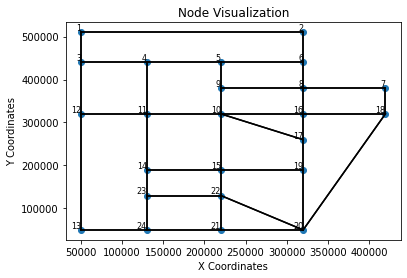

In [6]:
plt.scatter(x, y)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Node Visualization')
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord, str(i+1), fontsize=8, verticalalignment='bottom', horizontalalignment='right')
for _, row in connection_df.iterrows():
    start_node = row['A']
    end_node = row['B']
    plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-')
plt.show()

In [7]:
data = pd.read_csv('capacity.tntp',  delimiter='\t', skiprows=5)
headers = data.iloc[0]
data = data.iloc[0+1:].reset_index(drop=True)
data.columns = headers
data = data.drop('~', axis=1)

In [8]:
import pandas as pd
import networkx as nx
import concurrent.futures

# Read the DataFrame with connections and capacities
df = data

# Create a directed graph
G = nx.DiGraph()

# Convert capacity to integers
df['capacity'] = df['capacity'].astype(float)

# Add nodes to the graph
G.add_nodes_from(df['init_node'])
G.add_nodes_from(df['term_node'])

# Add edges to the graph with capacities as edge attributes
for _, row in df.iterrows():
    init_node = row['init_node']
    term_node = row['term_node']
    capacity = row['capacity']
    G.add_edge(init_node, term_node, capacity=capacity)

# Function to find the optimal route for a pair of nodes
def find_optimal_route(start_node, end_node):
    return nx.shortest_path(G, start_node, end_node, weight='capacity')

# Find all possible routes and select the optimal route for each pair of nodes
routes = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_pair = {executor.submit(find_optimal_route, start_node, end_node): (start_node, end_node) for start_node in G.nodes for end_node in G.nodes if start_node != end_node}
    for future in concurrent.futures.as_completed(future_to_pair):
        pair = future_to_pair[future]
        try:
            optimal_route = future.result()
            route_capacity = min(G[u][v]['capacity'] for u, v in zip(optimal_route, optimal_route[1:]))
            routes.append({'start_node': pair[0], 'end_node': pair[1], 'route': optimal_route, 'capacity': route_capacity})
        except Exception as e:
            print(f"An error occurred for pair {pair}: {e}")

# Convert routes to a DataFrame
routes_df = pd.DataFrame(routes)

# Print the routes DataFrame
# print(routes_df)


In [9]:
routes_df['route_pairs'] = routes_df['route'].apply(lambda route: [f"{node}-{next_node}" for node, next_node in zip(route, route[1:])])

In [10]:
def find_distance(pair):
    node1, node2 = pair.split('-')
    x1 = node_df.iloc[int(node1) - 1]['X']
    x2 = node_df.iloc[int(node2) - 1]['X']
    y1 = node_df.iloc[int(node1) - 1]['Y']
    y2 = node_df.iloc[int(node2) - 1]['Y']
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [11]:
distances = dict()
for i in range(len(data)):
    distance = f"{data.iloc[i]['init_node']}-{data.iloc[i]['term_node']}"
    distances[distance] = find_distance(distance)

In [12]:

# Function to calculate the summary distance for a route pair
def calculate_summary_distance(route_pairs):
    return sum(distances.get(pair, 0) for pair in route_pairs)

# Calculate the summary distances for each route_pairs entity
routes_df['summary_distance'] = routes_df['route_pairs'].apply(calculate_summary_distance)

# Print the updated routes DataFrame with summary distances
# print(routes_df)


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Set the max_distance a car can drive without charging
# max_distance = 300000 # for example
# n_clusters = 20

# Filter routes that a car can drive without charging
viable_routes_df = routes_df[routes_df['summary_distance'] <= max_distance]

if viable_routes_df.empty:
    raise ValueError("No viable routes! Increase max_distance.")

# Now, we'll perform clustering on the 'capacity' of the routes
# Convert 'capacity' into a 2D numpy array
X = np.array(viable_routes_df['capacity']).reshape(-1, 1)

# Number of clusters corresponds to the number of desired charging stations

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

# Assign each route to a cluster
viable_routes_df['cluster'] = kmeans.labels_

charging_stations = []

# For each cluster, find the route with the maximum capacity
for i in range(n_clusters):
    cluster_routes = viable_routes_df[viable_routes_df['cluster'] == i]
    
    if cluster_routes.empty:
        continue  # Skip to the next iteration if there are no routes in this cluster
    
    # Choose the first route with the maximum capacity
    best_route = cluster_routes[cluster_routes['capacity'] == cluster_routes['capacity'].max()].iloc[0]
    
    # Choose the node with the highest capacity within this route
    nodes_in_route = best_route['route']
    node_capacities = [(node, routes_df[routes_df['start_node'] == node]['capacity'].max()) for node in nodes_in_route]
    best_node, _ = max(node_capacities, key=lambda x: x[1])
    
    # Add the best_node's coordinates to the list of charging stations
    charging_stations.append(node_df.loc[int(best_node)])

# Now charging_stations contains the coordinates of the charging stations.
print(charging_stations)


[X    320000
Y    510000
Name: 2, dtype: int64, X    420000
Y    320000
Name: 18, dtype: int64, X     50000
Y    440000
Name: 3, dtype: int64, X     50000
Y    510000
Name: 1, dtype: int64, X    220000
Y    380000
Name: 9, dtype: int64, X     50000
Y    510000
Name: 1, dtype: int64, X    420000
Y    380000
Name: 7, dtype: int64, X    320000
Y    510000
Name: 2, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    130000
Y    440000
Name: 4, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    320000
Y    510000
Name: 2, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    320000
Y     50000
Name: 20, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    50000
Y    50000
Name: 13, dtype: int64, X    320000
Y     50000
Name: 20, dtype: int64, X    320000
Y    320000
Name: 16, dtype: int64, X     50000
Y    440000
Name: 3, dtype: int64]


C:\Users\costy\AppData\Local\Temp\ipykernel_2388\3205371427.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viable_routes_df['cluster'] = kmeans.labels_


In [14]:
capacities = dict()
for i in range(len(data)):
    if data['term_node'][i] not in capacities.keys():
        capacities[data['term_node'][i]] = data['capacity'][i]
    else:
        capacities[data['term_node'][i]] += data['capacity'][i]    

In [15]:
# Convert charging_stations to a dictionary for uniqueness
charging_stations_dict = {station.name: station for station in charging_stations}

# Store the original number of charging stations
original_num_stations = len(charging_stations_dict)

# Sort the capacities dict based on values (in descending order)
sorted_capacities = dict(sorted(capacities.items(), key=lambda item: item[1], reverse=True))

# Iterate over the sorted capacities dict
for node, capacity in sorted_capacities.items():
    # If the node is not already in the charging_stations dictionary
    if int(node) not in charging_stations_dict:
        # Get the node from node_df and add it to the charging_stations dictionary
        charging_stations_dict[int(node)] = node_df.loc[int(node)]

    # Check if the number of charging stations is equal to n_clusters
    if len(charging_stations_dict) == n_clusters:
        break

# Convert the dictionary back to a list
charging_stations = list(charging_stations_dict.values())

# Calculate the number of new stations added
num_new_stations = len(charging_stations) - original_num_stations

if num_new_stations == 0 and len(charging_stations) < n_clusters:
    print("Not enough different stations to reach the desired number of clusters.")
else:
    print(f"Added {num_new_stations} new station(s) to charging_stations list.")


Added 9 new station(s) to charging_stations list.


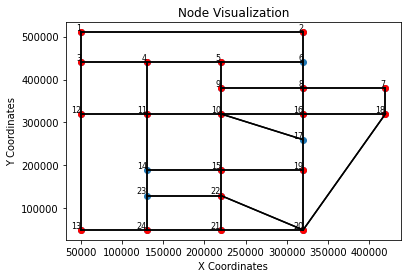

In [16]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Node Visualization')
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord, str(i+1), fontsize=8, verticalalignment='bottom', horizontalalignment='right')

# Extracting X and Y coordinates of charging stations
x_charging = [station['X'] for station in charging_stations]
y_charging = [station['Y'] for station in charging_stations]

# Plotting charging stations
plt.scatter(x_charging, y_charging, color='red')

for _, row in connection_df.iterrows():
    start_node = row['A']
    end_node = row['B']
    plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-')

plt.show()


In [17]:
def get_node_numbers(charging_stations, node_df):
    node_numbers = []
    for station in charging_stations:
        match = node_df[(node_df['X'] == station['X']) & (node_df['Y'] == station['Y'])]
        node_numbers.append(match.index[0])
    return node_numbers

# Call the function with your data
node_numbers = get_node_numbers(charging_stations, node_df)

# Print the node numbers of the charging stations
print(set(node_numbers))


{1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24}


In [18]:
def find_distances(route_pairs, node_numbers, distances_dict, max_distance):
    route_nodes = []
    charging_stations = []
    distances = []

    # Extract nodes from route pairs and add to route_nodes
    for route_pair in route_pairs:
        node_a, node_b = map(int, route_pair.split('-'))
        if node_a not in route_nodes:
            route_nodes.append(node_a)
        if node_b not in route_nodes:
            route_nodes.append(node_b)

    # Determine which nodes are charging stations
    for node in route_nodes:
        if node in node_numbers:
            charging_stations.append(node)

    # Special case when starting point is a charging station
    if route_nodes[0] in charging_stations:
        charging_stations.remove(route_nodes[0])

    if len(charging_stations) == 0:
        # No charging station, return the total route distance
        total_distance = 0
        for i in range(len(route_nodes)-1):
            total_distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
        distances.append(total_distance)
    else:
        # There are charging stations, calculate distances between them
        prev_station = route_nodes[0]
        for station in charging_stations:
            distance = 0
            i = route_nodes.index(prev_station)
            while i < len(route_nodes) and route_nodes[i] != station:
                distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
                i += 1
            distances.append(distance)
            prev_station = station

        # Distance from last charging station to end of route
        distance = 0
        i = route_nodes.index(prev_station)
        while i < len(route_nodes) - 1:
            distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
            i += 1
        distances.append(distance)

    return distances


In [19]:
# Apply the function to the 'route_pairs' column
routes_df['distances_between_stations'] = routes_df['route_pairs'].apply(
    lambda route_pairs: find_distances(
        route_pairs, 
        node_numbers, 
        distances, 
        max_distance
    )
)


In [20]:
def count_charging_stations(route_pairs, node_numbers):
    route_nodes = []
    charging_stations = []

    # Extract nodes from route pairs and add to route_nodes
    for route_pair in route_pairs:
        node_a, node_b = map(int, route_pair.split('-'))
        if node_a not in route_nodes:
            route_nodes.append(node_a)
        if node_b not in route_nodes:
            route_nodes.append(node_b)

    # Determine which nodes are charging stations
    for node in route_nodes:
        if node in node_numbers:
            charging_stations.append(node)

    # Special case when starting point is a charging station
    if route_nodes[0] in charging_stations:
        charging_stations.remove(route_nodes[0])

    return len(charging_stations)


# Apply the function to the 'route_pairs' column
routes_df['station_count'] = routes_df['route_pairs'].apply(
    lambda route_pairs: count_charging_stations(
        route_pairs, 
        node_numbers
    )
)


In [21]:
def check_max_distance(distances, max_distance):
    # Check if any distance in distances is greater than max_distance
    for distance in distances:
        if distance > max_distance:
            return False

    # If none of the distances are greater than max_distance
    return True


# Apply the function to the 'distances_between_stations' column
routes_df['within_max_distance'] = routes_df['distances_between_stations'].apply(
    lambda distances: check_max_distance(distances, max_distance)
)


In [22]:
sum(routes_df['within_max_distance'])/len(routes_df)

1.0

In [ ]:
routes_df[(routes_df['within_max_distance'] == True) & (routes_df['summary_distance'] > 299999)]

In [24]:
sum(routes_df['within_max_distance'])/len(routes_df)

1.0

In [25]:
routes_df

,start_node,end_node,route,capacity,route_pairs,summary_distance,distances_between_stations,station_count,within_max_distance
0,1,23,"[1, 3, 4, 11, 14, 23]",4876.508287,"[1-3, 3-4, 4-11, 11-14, 14-23]",460000.000000,"[70000.0, 80000.0, 120000.0, 190000.0]",3,True
1,1,22,"[1, 3, 4, 11, 14, 23, 22]",4876.508287,"[1-3, 3-4, 4-11, 11-14, 14-23, 23-22]",550000.000000,"[70000.0, 80000.0, 120000.0, 280000.0, 0]",4,True
2,2,1,"[2, 1]",25900.200640,[2-1],270000.000000,"[270000.0, 0]",1,True
3,1,19,"[1, 2, 6, 8, 16, 17, 19]",4823.950831,"[1-2, 2-6, 6-8, 8-16, 16-17, 17-19]",590000.000000,"[270000.0, 130000.0, 60000.0, 130000.0, 0]",4,True
4,3,22,"[3, 4, 11, 14, 23, 22]",4876.508287,"[3-4, 4-11, 11-14, 14-23, 23-22]",480000.000000,"[80000.0, 120000.0, 280000.0, 0]",3,True
...,...,...,...,...,...,...,...,...,...
547,24,21,"[24, 21]",4885.357564,[24-21],90000.000000,"[90000.0, 0]",1,True
548,24,22,"[24, 23, 22]",5000.000000,"[24-23, 23-22]",170000.000000,"[170000.0, 0]",1,True
549,24,23,"[24, 23]",5078.508436,[24-23],80000.000000,[80000.0],0,True
550,17,15,"[17, 10, 15]",4993.510694,"[17-10, 10-15]",246619.037897,"[116619.03789690601, 130000.0, 0]",2,True


In [27]:
distances

{'1-2': 270000.0,
 '1-3': 70000.0,
 '2-1': 270000.0,
 '2-6': 70000.0,
 '3-1': 70000.0,
 '3-4': 80000.0,
 '3-12': 120000.0,
 '4-3': 80000.0,
 '4-5': 90000.0,
 '4-11': 120000.0,
 '5-4': 90000.0,
 '5-6': 100000.0,
 '5-9': 60000.0,
 '6-2': 70000.0,
 '6-5': 100000.0,
 '6-8': 60000.0,
 '7-8': 100000.0,
 '7-18': 60000.0,
 '8-6': 60000.0,
 '8-7': 100000.0,
 '8-9': 100000.0,
 '8-16': 60000.0,
 '9-5': 60000.0,
 '9-8': 100000.0,
 '9-10': 60000.0,
 '10-9': 60000.0,
 '10-11': 90000.0,
 '10-15': 130000.0,
 '10-16': 100000.0,
 '10-17': 116619.03789690601,
 '11-4': 120000.0,
 '11-10': 90000.0,
 '11-12': 80000.0,
 '11-14': 130000.0,
 '12-3': 120000.0,
 '12-11': 80000.0,
 '12-13': 270000.0,
 '13-12': 270000.0,
 '13-24': 80000.0,
 '14-11': 130000.0,
 '14-15': 90000.0,
 '14-23': 60000.0,
 '15-10': 130000.0,
 '15-14': 90000.0,
 '15-19': 100000.0,
 '15-22': 60000.0,
 '16-8': 60000.0,
 '16-10': 100000.0,
 '16-17': 60000.0,
 '16-18': 100000.0,
 '17-10': 116619.03789690601,
 '17-16': 60000.0,
 '17-19': 70000.0